## Imports

In [58]:
using LinearAlgebra
using Plots 
using OrdinaryDiffEq
using Statistics

include("src/IRK8.jl");

## Three-body problem
The gravitational N-body problem is a problem where the initial positions, velocities, and masses of N point masses are given, and their following motion under Newton's law of universal gravitation needs to be determined.

The planar three-body problem is a special case of the N-body problem where we are dealing with three bodies on a plane.

The motion of the three bodies can be defined in terms of a system of differential equations for vector positions $q_i = (x_i, y_i)$:
$$
\ddot q_i = G \sum_{j \neq i} m_j \frac{(q_j-q_i)}{\|q_j-q_i\|^3}\
$$

## Three-body choreograpy

Definition of choreography.

Because of the permutation symmetry of choreographies, we know that all masses must be equal. More so, because of the scalability property of the N-body problem, all three masses and $G$ can all be set to equal one. The differential equations can be rewritten to take this into account:

$$
\ddot q_i = \sum_{j \neq i} \frac{(q_j-q_i)}{\|q_j-q_i\|^3}\
$$

Where $G$ is the universal gravitational constant.

## Relative coordinate system

The relative error of floating point subraction is _baldintzapen txarra?_ when $y \approx x$:

$$\left|\frac{x}{x-y}\right| |\delta_x| + \left|\frac{y}{x-y}\right| |\delta_y|$$

A relative coordinate system can be used in order to avoid an excessive cumulative error.

\begin{equation*}
\begin{split}
x_{ij} &:= x_j - x_i \\
y_{ij} &:= y_j - y_i
\end{split} 
\end{equation*}

where $(i, j) = (1, 2), (2, 3), (3, 1)$

The differential equations can be rewritten for $q_{ij} = (x_{ij}, y_{ij})$:

\begin{equation*}
\begin{split}
\ddot q_{12} &= -2 \frac {q_{ij}}{\|q_{ij}\|} + \frac {q_{31}}{\|q_{31}\|} + \frac {q_{23}}{\|q_{23}\|} \\
\ddot q_{23} &= -2 \frac {q_{23}}{\|q_{23}\|} + \frac {q_{12}}{\|q_{12}\|} + \frac {q_{31}}{\|q_{31}\|} \\
\ddot q_{31} &= -2 \frac {q_{31}}{\|q_{31}\|} + \frac {q_{23}}{\|q_{23}\|} + \frac {q_{12}}{\|q_{12}\|} 
\end{split}
\end{equation*}

Energy of the system in terms of relative variables:
$$
E = \dots
$$

To implement the equations above, we will first represent them in compact form:

$$
\frac{d}{dt} u = f(u),
$$
where 
$$
u = (x_1,y_1,x_2,y_2,x_3,y_3,\dot x_1,\dot y_1,\dot x_2, \dot y_2, \dot x_3, \dot y_3, \beta)
$$

In [8]:
function ThreeBodyEnergy(u)
    norm12 = sqrt(u[1]^2+u[2]^2)
    norm23 = sqrt(u[3]^2+u[4]^2)
    norm31 = sqrt(u[5]^2+u[6]^2)
    return (u[7]^2+u[8]^2+u[9]^2+u[10]^2+u[11]^2+u[12]^2)/2 - 
           (1/norm12 + 1/norm23 + 1/norm31)
end

function ThreeBodyODE!(du,u,p,t)
    q12 = [u[1], u[2]]
    q23 = [u[3], u[4]]
    q31 = [u[5], u[6]]
    aux12 = q12*dot(q12, q12)^-1.5
    aux23 = q23*dot(q23, q23)^-1.5
    aux31 = q31*dot(q31, q31)^-1.5
    dv1 = aux12 - aux31
    dv2 = aux23 - aux12 
    dv3 = aux31 - aux23       
    @. du[1:4] = u[9:12] - u[7:10] 
    @. du[5:6] = u[7:8] - u[11:12]
    du[7:12] .= [dv1[1], dv1[2], dv2[1], dv2[2], dv3[1], dv3[2]]
    du[13] = 1
    return nothing
end

ThreeBodyODE! (generic function with 1 method)

We will only be working with choreographies that are fixed at (0, 0), in other words, $|q_1 + q_2 + q_3|= 0$. Because of this, we can easily convert from relative to absolute coordinates the following way:

\begin{equation*}
\begin{split}
q_1 &= \frac13 (q_{31} - q_{12}) \\
q_2 &= \frac13 (q_{12} - q_{23}) \\
q_3 &= \frac13 (q_{23} - q_{31}) \\
\end{split}
\end{equation*}

This is because, for example, $q_{31}-q_{12} = q_1 - q_3 - q_2 + q_1 = 3q_1 - q_1 - q_2 - q_3 = 3 q_1$

In [6]:
abs2rel(u) = [u[1]-u[3], u[2]-u[4], u[3]-u[5], u[4]-u[6], u[5]-u[1], u[6]-u[2],
                 u[7]-u[9], u[8]-u[10], u[9]-u[11], u[10]-u[12], u[11]-u[7], u[12]-u[8]]

function rel2abs(u)
    x1 = (u[5]-u[1])/3.
    x2 = (u[1]-u[3])/3.
    x3 = (u[3]-u[5])/3.
    y1 = (u[6]-u[2])/3.
    y2 = (u[2]-u[4])/3.
    y3 = (u[4]-u[6])/3.
    
    vx1 = (u[11]-u[7])/3.
    vx2 = (u[7]-u[9])/3.
    vx3 = (u[9]-u[11])/3.
    vy1 = (u[12]-u[8])/3.
    vy2 = (u[8]-u[10])/3.
    vy3 = (u[10]-u[12])/3.
    
    return [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]
end

rel2abs (generic function with 1 method)

## Global time renormalization

Brief explanation.

An appropriate function $s(u)$ is chosen for time renormalization and a new independent variable $\tau$ is defined:
$$
\tau = \int_0^t \frac{d t'}{s(u(t'))}.
$$

When applying time renormalization, $u$ is represented as a function of the ficticious time: 
$$
\frac{d}{d\tau} u = s(u)\, f(u)  \tag{1}
$$
Since all three bodies have equal mass, uniform global time renormalization can be defined entirely in terms of positions of the bodies:

\begin{equation*}
s(q_{12}, q_{23}, q_{31}) = 
\left( \sum \frac{1}{\|q_{ij}\|^2}\right)^{-1/2}
\left( \sum \frac{1}{\|q_{ij}\|}\right)^{-1/2}
\end{equation*}

In [25]:
function ThreeBodyODEGlobalTR!(du,u,p,t)
    q12 = [u[1], u[2]]
    q23 = [u[3], u[4]]
    q31 = [u[5], u[6]]
    dot12 = dot(q12, q12)
    dot23 = dot(q23, q23)
    dot31 = dot(q31, q31)
    norm12 = sqrt(dot12)
    norm23 = sqrt(dot23)
    norm31 = sqrt(dot31)
    aux12 = q12/(dot12*norm12)
    aux23 = q23/(dot23*norm23)
    aux31 = q31/(dot31*norm31)
    dv1 = aux12 - aux31
    dv2 = aux23 - aux12
    dv3 = aux31 - aux23    
    @. du[1:4] = u[9:12] - u[7:10] 
    @. du[5:6] = u[7:8] - u[11:12]
    du[7:12] .= [dv1[1], dv1[2], dv2[1], dv2[2], dv3[1], dv3[2]]
    A = 1/dot12+1/dot23+1/dot31
    B = 1/norm12+1/norm23+1/norm31
    s = (A*B)^-0.5
    @. du *= s  
    du[13] = s  
    return nothing
end

ThreeBodyODEGlobalTR! (generic function with 1 method)

To check that the code above works, we are going to compute the curve of the figure eight choreography.

Initial state of the choreography: 

In [66]:
u0 = [4.174267456512568, -0.8888058233705901, 0.0, 1.7776116467411802, -4.174267456512568, -0.8888058233705901, 1.1102230246251565e-16, 0.2911946973117171, 0.683796458425381, -0.14559734865585836, -0.6837964584253811, -0.14559734865585874, 0.0]
T = 5.372134247663828

A Runge-Kutta method of order 8 is used for the integration. We store 256 points of the curve, and for higher accuracy we compute 16 more in between each pair. 

We can use a constant time step without worrying about integration error because of the global time renormalization that we applied to the differential equations.

In [67]:
odef = ThreeBodyODEGlobalTR!
p = nothing
n = 256
m = 16;

In [68]:
sol = IRK8(u0, 0., T, n, m, odef, p);
uu = sol.u;

Package 'Plots' is used to display the curve. It is first converted to absolute coordinates, and then we plot the path of each body.

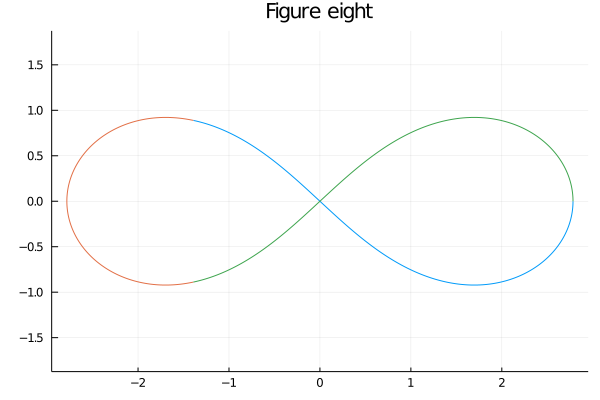

In [69]:
pl = plot(title="Figure eight", aspect_ratio=1)

uu_abs = [rel2abs(u) for u in uu]
for j in 1:3
    xx = [u[2*(j-1)+1] for u in uu_abs]
    yy = [u[2*(j-1)+2] for u in uu_abs]
    
    plot!(xx,yy,legend=false)
end

display(pl)

The energy of the system was set to $-\frac12$ initially:

In [70]:
ThreeBodyEnergy(u0)

-0.4999999999999998

Because of the law of conservation of energy, we know that the energy shouldn't change throguout time. 

To verify this, we calculate the energy of the system at each moment in time, and then we compute the standard deviation. If and only if all the values are equal to $-\frac12$, the standard deviation will be zero:

In [71]:
ee = [ThreeBodyEnergy(u) for u in uu]
deviation = std(ee)

1.1080524985517892e-16

We will implement a function that takes the initial state of a system and displays it for us, as it is going to be extremely useful for visualization.

In [103]:
function visualize(u0, odef, p, T0, Tend, n, m, title="", triangles=false)
    odef = ThreeBodyODEGlobalTR!
    p = nothing
    n = 256
    m = 16;
    sol = IRK8(u0, T0, Tend, n, m, odef, p);
    uu = sol.u;
    pl = plot(title=title, aspect_ratio=1)

    uu_abs = [rel2abs(u) for u in uu]
    for j in 1:3
        xx = [u[2*(j-1)+1] for u in uu_abs]
        yy = [u[2*(j-1)+2] for u in uu_abs]

        plot!(xx,yy,legend=false)
    end
    
    if triangles
        u0_abs = uu_abs[1]
        uT_abs = uu_abs[end]
        plot!([u0_abs[i] for i in [1, 3, 5, 1]], [u0_abs[i] for i in [2, 4, 6, 2]], color="gray")
        plot!([uT_abs[i] for i in [1, 3, 5, 1]], [uT_abs[i] for i in [2, 4, 6, 2]], color="purple")
    end

    display(pl)
    #return sol.retcode
end

visualize (generic function with 3 methods)

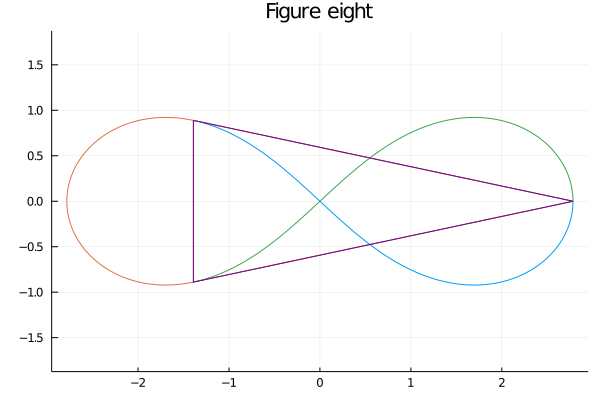

In [104]:
visualize(u0, odef, p, 0., T, n, m, "Figure eight", true)

## Advantages of global time renormalization

Comparison with adaptive methods for integration.

Fourier series stuff.